In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'.')

## What are foundation models?

Foundation Models are taking deep learning by storm. So much so, that Stanford has now set up a <a href="https://crfm.stanford.edu/"> center for research on foundation models </a>. Their <a href="https://arxiv.org/abs/2108.07258"> report </a> titled **On the opportunities and risks of foundation models** is a great resource to deep dive into what foundation models are and what potential, both positive and negative, they represent. To quote from the abstract, foundation models are **"models (e.g., BERT, DALL-E, GPT-3) that are trained on broad data at scale and are adaptable to a wide range of downstream tasks. We call these models foundation models to underscore their critically central yet incomplete character."**

## Okay, so what is the big deal?

Despite the obvious issues with their cost and the access issues it creates, what has excited a lot of people can be summarized in the following graph from the **Language models are few-shot learners** paper (of GPT3 fame). 

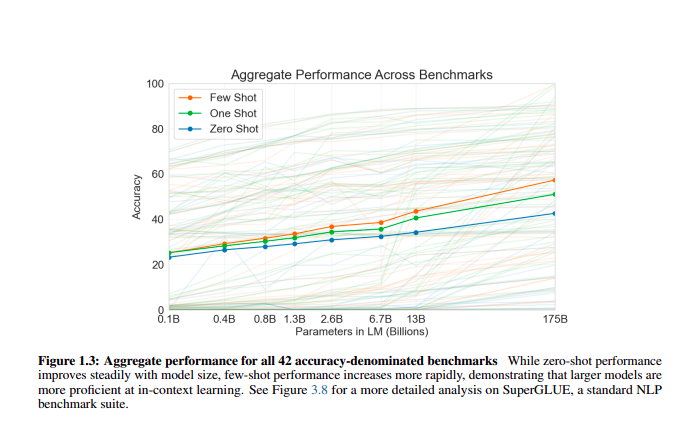

Even the harshest critic, and I count myself as sympathetic to that group, of the Foundation Model approach has to relent that there is something interesting going on in the graph above. As we increase the model size the language model being trained, they somehow keep getting better at solving a wide variety of different tasks! This paradigm of few-shot learning - now dubbed in-context learning - is truly a new and extremely promising method of supervised learning. And this is motivation enough for the proposed GPT4 model which reportedly will have a 100 trillion parameters! 

( How in-context learning works is subject of research. There are some tantalizing clues in the recent **An Explanation of In-context Learning as Implicit Bayesian Inference** paper. Though it is safe to say that the final word on this has yet to be said.)

Irrespective of how in-context learning works, it is an interesting tool for practictioners to play around with. For most supervised problems the current in-context learning performance is not good enough out of the box - things may change with GPT4, if and when it arrives. 

One potentially interesting use-case for foundation models that I am playing around with, is using them for advanced EDA of text datasets. The idea is very simple. Since one can use foundation models to build classifiers "on-the-fly", why not use it to semantically explore the dataset? So, for example, let us say you are given a dataset of tweets which are labelled as whether or not they are talking about a disaster. The labels are 1 if the tweet is a "disaster tweet" and 0 otherwise. Let us take a look at some samples from such a dataset.

In [3]:
#setup dataset location
dataset_location = '/media/aman/8a3ffbda-8a36-45f9-b426-d146a65d9ece/data1/qa4ml/demo_data/disaster_dataset/train.csv'
prompt_file_location = '/media/aman/8a3ffbda-8a36-45f9-b426-d146a65d9ece/data1/qa4ml/src/prompt.json'
openai_api_file_location = '/media/aman/8a3ffbda-8a36-45f9-b426-d146a65d9ece/data1/qa4ml/src/opeai_param.json'

In [4]:
from collections import Counter
import pandas as pd
df = pd.read_csv(dataset_location)
pd.set_option("display.max_colwidth", -1)
df.sample(n=10)

/tmp/ipykernel_24317/3648948031.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,id,keyword,location,text,target
4027,5719,forest%20fire,NaN,@Sweet2Young -runs at her for setting my forest on fire and bites the shit out of her neck-,1
1392,2009,casualties,indiana,That triumphant moment when you cook up two eggs over easy with no yolk casualties ?? http://t.co/fQJ5Aga1pd,0
2524,3627,desolation,"2B Hindhede Rd, Singapore",In times of desolation and trouble Daniel's persistent prayers and fastings brought forth heavenly power and God iÛ_ http://t.co/wOx3VpRixQ,0
4501,6398,hurricane,NaN,They should name hurricanes with black people names. I'd be terrified of hurricane Shanaynay!,0
648,939,blaze,"Atlanta,Ga",Welcome @djryanwolf @djcoreygrand @djknyce @djoneplustwo @OfficialCoreDJs #Family #Cleveland #StandUp @IAMTONYNEAL http://t.co/P6GqmCTgLj,0
5383,7681,panic,worldwide,@montetjwitter11 @Mets @audreyp77 @teena_797 @darryl_brooks @EliteSportsNY @LopezandtheLion no panic from #NatsNation but concern for sure,0
6527,9337,survive,NaN,#Autoinsurance industry clueless on driverless cars : #healthinsurance http://t.co/YdEtWgRibk,1
689,993,blazing,Between the worlds,I'm the only weapons master here! Let's go in guns blazing!\n#Hinatobot,0
2008,2884,damage,London/New York,#pt Cross-sectarian protest. Powerful Shia cleric says militias must withdraw:'ur fightin ISIS but we wont forget damage uve done to ur ppl',1
6787,9723,tragedy,India,Railways caught unawares by MP tragedy; Accident spot never marked as 'vulnerable' - Times ofÛ_ http://t.co/cEdCUgEuWs #News,1


In [5]:
from collections import Counter
disaster_keywords = Counter(df[df.target==1].keyword)
print(sorted(disaster_keywords.items(),key=lambda x:x[1], reverse=True)[:20])


[(nan, 42), ('derailment', 39), ('outbreak', 39), ('wreckage', 39), ('debris', 37), ('oil%20spill', 37), ('typhoon', 37), ('evacuated', 32), ('rescuers', 32), ('suicide%20bomb', 32), ('suicide%20bombing', 32), ('nuclear%20disaster', 31), ('razed', 31), ('airplane%20accident', 30), ('earthquake', 30), ('suicide%20bomber', 30), ('bridge%20collapse', 29), ('collision', 29), ('wildfire', 29), ('buildings%20on%20fire', 28)]


As we can see the dataset, apart from containing the labels, also contains a field called keyword which tells something about the content of the tweet itself. In a real life problem, such information may not be available or partially available. However the product requirements might be such that certain categories of data, which are not labelled as such, require to be treated specially for model design and evaluation purposes. For instance, the data scientist may be interested in know which tweets in the training set talk about a "news event" vs which ones are casual tweets.

## Before we begin

In order to use GPT3 apis, you need to create an account with OpenAI. The APIs are not free and the pricing is quite steep. The biggest model, Davinci, costs about 6 cents for every 1000 tokens. Compare that to around 0.05 cents per 1000 words for NER extraction service of AWS comprehend. Add the fact that a token for GPT3 is a word-piece and not a word - and the cost begins to stack up quickly.

An open-source alternative to using GPT3 is <a href="https://huggingface.co/docs/transformers/model_doc/gptj"> GPT-J</a>. But compared to the 170B params of GPT3, GPT-J only has about 6B. Which, by the above graph, can reduce the performance by 33pc.

For this study, I am using the OpenAI apis. It will be interesting to compare the results with open source alternatives in the future. 

### News tweet classifier
Let us say we want to see how many of the tweets in our dataset provide some news related information as opposed to a casual tweet. So a tweet like "Fire crews evacuate passengers from a Gold Coast tram trapped when powerlines fell across a carriage. #TenNews 5pm http://t.co/hFyrloQY8q" or "#Breaking #News - Call for Tasmania's emergency services to be trained in horse ... - http://t.co/urJwsVr311 http://t.co/7JfrETeIi4" are news tweets. While those like "A person who blows himself up to kill others has no life in heaven because his ethereal body gets destroyed by doing it." or "There's a #fly loose in my workspace with two #bored #cats. I forsee terrible things.  #destruction #badkitty #thisiswhywecanthavenicethings" are casual.

Ok, so now let us setup the in-context prompt. Here we are using the <a href="https://beta.openai.com/docs/api-reference/completions"> Completions </a> api by OpenAI. They have also now added a classification API which is more suitable for this. But the underlying code for this was written some time back. So we will make do with completions for now. The basic utility of the model remains unchanged.

In [42]:
import json
with open(prompt_file_location) as pfl:
    prompt = json.load(pfl)

print(prompt)

{'prompt_type': 0, 'problem_type': 0, 'prompt_text': 'This is a factual tweet classifier\\n\\n\\nTweet: \\"#Breaking #News - Call for Tasmania\'s emergency services to be trained in horse ... - http://t.co/urJwsVr311 http://t.co/7JfrETeIi4\\"\\nClass: Yes\\n###\\nTweet: \\"Fire crews evacuate passengers from a Gold Coast tram trapped when powerlines fell across a carriage. #TenNews 5pm http://t.co/hFyrloQY8q\\"\\nClass: Yes\\n###\\nTweet: \\"A person who blows himself up to kill others has no life in heaven because his ethereal body gets destroyed by doing it.\\"\\nClass: No\\n###\\nTweet: \\"There\'s a #fly loose in my workspace with two #bored #cats. I forsee terrible things.  #destruction #badkitty #thisiswhywecanthavenicethings\\"\\nClass: No\\n###\\nTweet: \\"', 'aug_suffix': '\\"\\nClass:'}


We create the prompt using the 4 tweets shown above as examples.

In [36]:

import json

from src.operations import RandomSampler, DisasterTweetDatasetReader, PromptBasedCaseDetectionCriteriaCreator,\
FoundationModelAPIWrapper,PromptBasedSubsetCreatorFromCriteriaCreator,SubsetCountSummarizer, ConditionSampler
from src.services.EDAService import SubsetSummaryEDAService
from src.models import Prompt

def run_classification(sampling_ratio=0.005, seed=None):
    #matching_function = lambda x:x._metadata['keyword'] == 'displaced' and x._label=='1'
    #sampler = ConditionSampler(matching_function)
    sampler = RandomSampler(sampling_ratio,seed=seed)
    reader = DisasterTweetDatasetReader()
    prompt = Prompt.load_from_file(prompt_file_location)
    subset_criteria_creator = PromptBasedCaseDetectionCriteriaCreator(prompt)
    api_wrapper = FoundationModelAPIWrapper(json.load(open(openai_api_file_location)))
    subset_creator = PromptBasedSubsetCreatorFromCriteriaCreator(subset_criteria_creator,api_wrapper)
    summarizer = SubsetCountSummarizer(verbose=True)
    service = SubsetSummaryEDAService(sampler,subset_creator,summarizer,reader)
    summary = service.run_eda(dataset_location)
    print(summary)

In [37]:
run_classification(seed=42)



 Yes\n
0: &gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z
@esquireattire
1: Stony Jackson is America's last hope as he leads an army of felons thus and army rejects against the army o Satan - http://t.co/0wbEcdMHQo
2: Palestinian Teen Killed Amid Protests Against Arson Attack http://t.co/okVsImoGic
3: The Body Bags has a show on 08/07/2015 at 07:30 PM @ Tremont Music Hall in Charlotte NC http://t.co/FpKiqbus9r #concert
4: @roughdeal1 ante hudhud cyclone Chandrababu Valle ne ante Ga?
5: RT kurtkamka: Beautiful desolation. Just me a couple of coyotes some lizards and the morning sun. #Phoenix #ArizÛ_ http://t.co/0z1PvJVdpf
6: Putin's plan to destroy Western food en masse is causing a huge public backlash http://t.co/FAJbxz5kar
7: 70 Years After Atomic Bombs Japan Still Struggles With Wartime Past: The anniversary of the devastation wroug... http://t.co/EfsA6pbeMC
8: I'm drowning in hw now and that's w/o going to swim 

The tweets under the heading "Yes" have been classified as news tweets by the model. And those under the heading "No" are casual tweets. Out of the predicted news tweets, 6 tweets look casual to me. And out of the predicted casual tweets,4 like news tweets. That is a precision of 67pc and recall of 75pc. Let's not fix the seed and run this a couple of more times

In [38]:
run_classification()



 Yes\n
0: http://t.co/7xGLah10zL Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/THmblAATzP
1: New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet
2: What if every 5000 wins in ranked play gave you a special card back.. Would be cool for the long teÛ_ http://t.co/vq3yaB2j8N
3: Lizard Wizard in a Blizzard #LWB http://t.co/MgR809yc5a
4: New Ladies Shoulder Tote Handbag Women Cross Body Bag Faux Leather Fashion Purse - Full reÛ_ http://t.co/y87Gi3BRlV http://t.co/1zbhVDCXzS
5: @MzGracieBaby for the record im jumpin out the window early... i got @OfficialRealRap body bagging luck.. lol save the file
6: Sioux City Fire Officials Believe Bridge Collapse Lead To Cement Truck Roll Over - Siouxland Matters: Siouxlan... http://t.co/sZTGmbkoHG
7: Burning buildings? Media outrage? http://t.co/pHixZnv1YN
8: Please keep Josh the Salyers/Blair/Hall families &amp; Jenna's friends in your prayers. She was taken fa

Again, manually evaluating this set, the precision seems to be 53pc and the recall seems to be 82pc.

In [39]:
run_classification()



 No\n
0: Enjoyed live-action Attack on Titan but every time I see posters I'm reminded how freshly clean and coiffed everyone is in the apocalypse.
1: Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x
2: @smallforestelf Umm because a gun stopped the gunman with who was carrying a bomb!
3: Holy fuck QVC bitch just got burned so hard.
4: disinfo: Warfighting Robots Could Reduce Civilian Casualties So Calling for a Ban Now Is ... -... http://t.co/yUinMErQ2s #criticalmedia
5: Trains derailment: 'It's the freakiest of freak accidents' - The Indian Express http://t.co/cEdCUgEuWs #News  #topstories
6: Black Ops 3 SEARCH AND DESTROY GAMEPLAY! (Hunted SnD Competitive Multiplayer): http://t.co/ss1zL36y9V via @YouTube
7: #SCSeEstaPreparando Light mag. 4.4 earthquake  - - 73km SW of Khuzdar Pakistan on Wednes... http://t.co/i6lmcccLv5 via @volcanodiscover
8: Do babies actually get electrocuted from wall sockets? I'm wonderin

Precision: 42pc Recall: 62pc

Combining the three runs above:

In [41]:
import numpy as np
mean_precision = np.mean([42,67,62])
stdev_precision = np.std([42,67,62])
mean_recall = np.mean([75,82,62])
stdev_recall = np.std([75,82,62])
mean_precision,stdev_precision,mean_recall,stdev_recall

(57.0, 10.801234497346433, 73.0, 8.286535263104035)

### Conclusion and next steps

Ok. So the precision is quite low. And the standard deviation for both precision and recall is pretty high. However, this is certainly a pretty good starting point given we have trained no model and used only 2 data points for negative and positive examples!! To put it in perspective, using a model with 73pc recall and 57pc precision, one can isolate roughly 75pc of the news related tweets to a subset 60pc the size of the original dataset.

There are a number of things that we can do next to improve upon this performance:

1. Iterative self training: We can provide some of the misclassified examples as further examples for in-context learning. Keep in mind if we do that, we should be careful to not evaluate on the same set but create a separate validation set.
2. Ensembling: We can create multiple "models" using different examples and combine the results using bagging.
3. Hyperparameter tuning: OpenAI provides a temperature hyperparameter that can do 
4. Confidence scores: We can improve upon the precision at the cost of coverage by using the logprobs that the API returns
5. Prompt engineering: There are number of methods for better manual and automated prompt engineering that can be tried for improved performance. 

Perhaps, I will get to exploring these techniques some other day. But prima facie, it looks like Foundation Models can help with directed exploration of datasets by creating arbitrary classifiers using only a small number of examples. 